In [ ]:
data_dir = "/content/drive/MyDrive/Quora-Data/"

In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
with open(data_dir + "pre-processing/glove_twiiter_100_max_train", "rb") as f:
    X_train_max = pickle.load(f)
with open(data_dir + "pre-processing/glove_twiiter_100_max_test", "rb") as f:
    X_test_max = pickle.load(f)
with open(data_dir + "pre-processing/glove_twiiter_100_avg_train", "rb") as f:
    X_train_avg = pickle.load(f)
with open(data_dir + "pre-processing/glove_twiiter_100_avg_test", "rb") as f:
    X_test_avg = pickle.load(f)
Y_train = pd.read_csv(data_dir + "pre-processing/train.csv")["Y"].values
Y_test = pd.read_csv(data_dir + "pre-processing/test.csv")["Y"].values

X_train, X_test = X_train_avg, X_test_avg

def remove_nan(X, Y):
    Y = Y[~np.isnan(X).any(axis=1)]
    X = X[~np.isnan(X).any(axis=1)]
    return X, Y

X_train, Y_train = remove_nan(X_train, Y_train)
X_test, Y_test = remove_nan(X_test, Y_test)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

X_train_t = torch.from_numpy(X_train.astype('float32'))
X_test_t = torch.from_numpy(X_test.astype('float32'))
X_val_t = torch.from_numpy(X_val.astype('float32'))
Y_train_t = torch.from_numpy(Y_train)
Y_test_t = torch.from_numpy(Y_test)
Y_val_t = torch.from_numpy(Y_val)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
loss_list_train = []
loss_list_val = []
accuracy_list_train = []
accuracy_list_val = []
iteration_list_val = []
iteration_list_train = []
loss_train_epoch = []

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(200, 128),
    torch.nn.ReLU(),
    #torch.nn.Dropout(0.2),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    #torch.nn.Dropout(0.2),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    #torch.nn.Dropout(0.2),
    torch.nn.Linear(32, 1)
    #torch.nn.Sigmoid()
    #torch.nn.Softmax()
)
# inp_dim = 200
# class Net(nn.Module):
#     def __init__(self, input_shape):
#         super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 1)

#     def forward(self,x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.sigmoid(self.fc3(x))
#         return x
# model = Net(input_shape=inp_dim)

model.to(device)
num_epochs = 4
count = 0
batch_size = 100

class MyDataset(Dataset):
    def __init__(self, X, Y, transform = None):
        self.transform = transform
        self.X = torch.tensor(X, dtype=torch.float32) #X
        self.Y = torch.tensor(Y, dtype=torch.float32) #torch.from_numpy(np.asarray(Y).astype('long'))

    def __getitem__(self, index):
        label = self.Y[index]
        image = self.X[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.X)

error = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()

# After running several times, this was found to be the best
learning_rate = 0.002
# https://pytorch.org/docs/stable/optim.html
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.008)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%50 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 50, Val Loss: 411.627, Val Accuracy: 0.628 Train Loss: 1646.750, Train Accuracy: 0.631
Iteration: 100, Val Loss: 408.602, Val Accuracy: 0.648 Train Loss: 1631.936, Train Accuracy: 0.650
Iteration: 150, Val Loss: 396.559, Val Accuracy: 0.670 Train Loss: 1584.500, Train Accuracy: 0.672
Iteration: 200, Val Loss: 390.569, Val Accuracy: 0.680 Train Loss: 1560.761, Train Accuracy: 0.681
Iteration: 250, Val Loss: 387.820, Val Accuracy: 0.683 Train Loss: 1547.008, Train Accuracy: 0.685
Iteration: 300, Val Loss: 381.406, Val Accuracy: 0.693 Train Loss: 1521.214, Train Accuracy: 0.695
Iteration: 350, Val Loss: 381.700, Val Accuracy: 0.690 Train Loss: 1522.364, Train Accuracy: 0.692
Iteration: 400, Val Loss: 378.831, Val Accuracy: 0.698 Train Loss: 1508.622, Train Accuracy: 0.701
Iteration: 450, Val Loss: 379.608, Val Accuracy: 0.691 Train Loss: 1512.323, Train Accuracy: 0.693
Iteration: 500, Val Loss: 379.562, Val Accuracy: 0.695 Train Loss: 1512.954, Train Accuracy: 0.698
Iteration: 

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.008)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%50 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 5600, Val Loss: 340.664, Val Accuracy: 0.733 Train Loss: 1343.530, Train Accuracy: 0.738
Iteration: 5650, Val Loss: 340.190, Val Accuracy: 0.732 Train Loss: 1340.121, Train Accuracy: 0.736
Iteration: 5700, Val Loss: 338.424, Val Accuracy: 0.736 Train Loss: 1334.849, Train Accuracy: 0.740
Iteration: 5750, Val Loss: 338.710, Val Accuracy: 0.736 Train Loss: 1336.611, Train Accuracy: 0.740
Iteration: 5800, Val Loss: 338.568, Val Accuracy: 0.735 Train Loss: 1334.079, Train Accuracy: 0.739
Iteration: 5850, Val Loss: 338.890, Val Accuracy: 0.736 Train Loss: 1335.683, Train Accuracy: 0.740
Iteration: 5900, Val Loss: 339.435, Val Accuracy: 0.733 Train Loss: 1335.443, Train Accuracy: 0.738
Iteration: 5950, Val Loss: 338.607, Val Accuracy: 0.734 Train Loss: 1332.317, Train Accuracy: 0.738
Iteration: 6000, Val Loss: 339.432, Val Accuracy: 0.734 Train Loss: 1337.321, Train Accuracy: 0.739
Iteration: 6050, Val Loss: 338.970, Val Accuracy: 0.735 Train Loss: 1335.093, Train Accuracy: 0.740


KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.008)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%50 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 8150, Val Loss: 335.262, Val Accuracy: 0.739 Train Loss: 1320.418, Train Accuracy: 0.743
Iteration: 8200, Val Loss: 334.987, Val Accuracy: 0.739 Train Loss: 1318.778, Train Accuracy: 0.743
Iteration: 8250, Val Loss: 334.451, Val Accuracy: 0.740 Train Loss: 1316.845, Train Accuracy: 0.744
Iteration: 8300, Val Loss: 334.334, Val Accuracy: 0.740 Train Loss: 1316.861, Train Accuracy: 0.745
Iteration: 8350, Val Loss: 333.995, Val Accuracy: 0.741 Train Loss: 1314.694, Train Accuracy: 0.745
Iteration: 8400, Val Loss: 333.837, Val Accuracy: 0.741 Train Loss: 1313.985, Train Accuracy: 0.745
Iteration: 8450, Val Loss: 333.876, Val Accuracy: 0.741 Train Loss: 1313.927, Train Accuracy: 0.746
Iteration: 8500, Val Loss: 334.020, Val Accuracy: 0.740 Train Loss: 1313.497, Train Accuracy: 0.744
Iteration: 8550, Val Loss: 333.832, Val Accuracy: 0.741 Train Loss: 1313.312, Train Accuracy: 0.745
Iteration: 8600, Val Loss: 333.592, Val Accuracy: 0.741 Train Loss: 1312.325, Train Accuracy: 0.746


KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%50 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 11600, Val Loss: 330.480, Val Accuracy: 0.744 Train Loss: 1297.247, Train Accuracy: 0.749
Iteration: 11650, Val Loss: 330.382, Val Accuracy: 0.744 Train Loss: 1296.376, Train Accuracy: 0.749
Iteration: 11700, Val Loss: 330.188, Val Accuracy: 0.744 Train Loss: 1295.715, Train Accuracy: 0.749
Iteration: 11750, Val Loss: 329.968, Val Accuracy: 0.745 Train Loss: 1295.241, Train Accuracy: 0.750
Iteration: 11800, Val Loss: 329.854, Val Accuracy: 0.744 Train Loss: 1294.366, Train Accuracy: 0.750
Iteration: 11850, Val Loss: 329.682, Val Accuracy: 0.745 Train Loss: 1293.515, Train Accuracy: 0.751
Iteration: 11900, Val Loss: 329.691, Val Accuracy: 0.745 Train Loss: 1293.431, Train Accuracy: 0.751
Iteration: 11950, Val Loss: 329.739, Val Accuracy: 0.745 Train Loss: 1292.952, Train Accuracy: 0.750
Iteration: 12000, Val Loss: 329.637, Val Accuracy: 0.745 Train Loss: 1292.716, Train Accuracy: 0.750
Iteration: 12050, Val Loss: 329.558, Val Accuracy: 0.746 Train Loss: 1292.347, Train Accura

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.00008
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 16000, Val Loss: 324.409, Val Accuracy: 0.751 Train Loss: 1262.536, Train Accuracy: 0.757
Iteration: 16500, Val Loss: 322.921, Val Accuracy: 0.753 Train Loss: 1256.591, Train Accuracy: 0.760
Iteration: 17000, Val Loss: 322.516, Val Accuracy: 0.752 Train Loss: 1252.747, Train Accuracy: 0.761
Iteration: 17500, Val Loss: 322.436, Val Accuracy: 0.752 Train Loss: 1248.963, Train Accuracy: 0.762
Iteration: 18000, Val Loss: 320.770, Val Accuracy: 0.755 Train Loss: 1243.902, Train Accuracy: 0.763
Iteration: 18500, Val Loss: 319.714, Val Accuracy: 0.754 Train Loss: 1239.625, Train Accuracy: 0.764
Iteration: 19000, Val Loss: 319.113, Val Accuracy: 0.754 Train Loss: 1233.444, Train Accuracy: 0.765
Iteration: 19500, Val Loss: 318.555, Val Accuracy: 0.756 Train Loss: 1228.109, Train Accuracy: 0.767
Iteration: 20000, Val Loss: 317.226, Val Accuracy: 0.757 Train Loss: 1221.295, Train Accuracy: 0.769
Iteration: 20500, Val Loss: 316.366, Val Accuracy: 0.757 Train Loss: 1218.284, Train Accura

KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.00008
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%5000 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 25000, Val Loss: 308.785, Val Accuracy: 0.764 Train Loss: 1176.233, Train Accuracy: 0.779
Iteration: 30000, Val Loss: 306.582, Val Accuracy: 0.766 Train Loss: 1146.740, Train Accuracy: 0.785


In [ ]:
learning_rate = 0.00008
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(20):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%5000 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 35000, Val Loss: 301.244, Val Accuracy: 0.771 Train Loss: 1110.532, Train Accuracy: 0.793
Iteration: 40000, Val Loss: 299.576, Val Accuracy: 0.773 Train Loss: 1081.816, Train Accuracy: 0.800
Iteration: 45000, Val Loss: 298.293, Val Accuracy: 0.773 Train Loss: 1061.492, Train Accuracy: 0.804
Iteration: 50000, Val Loss: 297.691, Val Accuracy: 0.774 Train Loss: 1046.654, Train Accuracy: 0.808
Iteration: 55000, Val Loss: 297.962, Val Accuracy: 0.776 Train Loss: 1028.843, Train Accuracy: 0.811
Iteration: 60000, Val Loss: 298.273, Val Accuracy: 0.775 Train Loss: 1018.684, Train Accuracy: 0.813
Iteration: 65000, Val Loss: 295.175, Val Accuracy: 0.778 Train Loss: 998.700, Train Accuracy: 0.818
Iteration: 70000, Val Loss: 294.036, Val Accuracy: 0.780 Train Loss: 988.580, Train Accuracy: 0.820
Iteration: 75000, Val Loss: 298.501, Val Accuracy: 0.778 Train Loss: 986.614, Train Accuracy: 0.820
Iteration: 80000, Val Loss: 296.491, Val Accuracy: 0.780 Train Loss: 980.952, Train Accuracy: 

In [ ]:
learning_rate = 0.00009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(20):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%5000 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 85000, Val Loss: 295.945, Val Accuracy: 0.781 Train Loss: 971.991, Train Accuracy: 0.823
Iteration: 90000, Val Loss: 294.446, Val Accuracy: 0.779 Train Loss: 965.948, Train Accuracy: 0.825
Iteration: 95000, Val Loss: 295.949, Val Accuracy: 0.779 Train Loss: 963.516, Train Accuracy: 0.826
Iteration: 100000, Val Loss: 293.704, Val Accuracy: 0.781 Train Loss: 956.561, Train Accuracy: 0.828
Iteration: 105000, Val Loss: 297.550, Val Accuracy: 0.780 Train Loss: 953.603, Train Accuracy: 0.827
Iteration: 110000, Val Loss: 296.817, Val Accuracy: 0.781 Train Loss: 948.938, Train Accuracy: 0.827
Iteration: 115000, Val Loss: 297.269, Val Accuracy: 0.781 Train Loss: 937.331, Train Accuracy: 0.831
Iteration: 120000, Val Loss: 298.060, Val Accuracy: 0.780 Train Loss: 933.099, Train Accuracy: 0.832
Iteration: 125000, Val Loss: 298.535, Val Accuracy: 0.779 Train Loss: 924.203, Train Accuracy: 0.835
Iteration: 130000, Val Loss: 302.583, Val Accuracy: 0.780 Train Loss: 926.512, Train Accuracy:

KeyboardInterrupt: ignored

In [ ]:
print("{:.2f}".format(1767.23823))

1767.24


In [ ]:
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(20):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%2500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 145000, Val Loss: 300.672, Val Accuracy: 0.784 Train Loss: 884.417, Train Accuracy: 0.844
Iteration: 147500, Val Loss: 297.644, Val Accuracy: 0.783 Train Loss: 876.001, Train Accuracy: 0.845
Iteration: 150000, Val Loss: 297.833, Val Accuracy: 0.783 Train Loss: 873.926, Train Accuracy: 0.846
Iteration: 152500, Val Loss: 298.813, Val Accuracy: 0.784 Train Loss: 874.343, Train Accuracy: 0.845
Iteration: 155000, Val Loss: 299.480, Val Accuracy: 0.784 Train Loss: 871.823, Train Accuracy: 0.846
Iteration: 157500, Val Loss: 299.303, Val Accuracy: 0.784 Train Loss: 870.402, Train Accuracy: 0.846
Iteration: 160000, Val Loss: 299.965, Val Accuracy: 0.784 Train Loss: 869.613, Train Accuracy: 0.847


KeyboardInterrupt: ignored

In [ ]:
learning_rate = 0.000005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
#optimizer = torch.optim.ASGD(model.parameters())
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
train_dataset = MyDataset(X_train_t, Y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = MyDataset(X_test_t, Y_test_t)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

val_dataset = MyDataset(X_val_t, Y_val_t)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

for curr_epoch in range(20):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        train = images #Variable(images)
        labels = labels #Variable(labels.view(len(labels),1))
        outputs = model(train)
        loss = error(outputs, labels.reshape(-1, 1))
        loss_list_train.append(loss.data)
        #print(loss.data)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
        count += 1
        model.eval()
        with torch.no_grad():
            if count%2500 == 0:
                # Y_pred = model(X_val_t.to(device))
                # loss_val = error(Y_pred, torch.tensor(Y_val_t, dtype=torch.float32).to(device).reshape(-1, 1))
                # Y_pred_lab = torch.round(torch.sigmoid(Y_pred))
                # accuracy = 1#(Y_pred_lab.cpu() == Y_val_t).sum()/len(Y_val_t)
                # Testing the model
                total = 0
                correct = 0
                loss_val = 0
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss_val += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                #print(correct, total)
                accuracy = correct/total
                loss_list_val.append(loss_val.data)
                iteration_list_val.append(count)
                accuracy_list_val.append(accuracy)
                print("Iteration: {}, Val Loss: {:.3f}, Val Accuracy: {:.3f}".format(count, loss_val.data, accuracy), end="")
        
                total = 0
                correct = 0
                loss = 0
                for images, labels in DataLoader(train_dataset, batch_size=batch_size):
                    images, labels = images.to(device), labels.to(device)
                    test = images #.view(batch_size, inp_dim))
                    outputs = model(test)
                    loss += error(outputs, labels.reshape(-1, 1)).data
                    predictions = torch.round(torch.sigmoid(outputs)) #torch.max(outputs, 1)[1].to(device)
                    correct += (predictions.reshape(-1) == labels).sum().item()
                    total += len(labels)
                accuracy = correct/total
                iteration_list_train.append(count)
                loss_train_epoch.append(loss)
                accuracy_list_train.append(accuracy)
                print(" Train Loss: {:.3f}, Train Accuracy: {:.3f}".format(loss.data, accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration: 162500, Val Loss: 299.347, Val Accuracy: 0.783 Train Loss: 870.942, Train Accuracy: 0.846
Iteration: 165000, Val Loss: 295.622, Val Accuracy: 0.784 Train Loss: 875.349, Train Accuracy: 0.846
Iteration: 167500, Val Loss: 292.813, Val Accuracy: 0.785 Train Loss: 880.868, Train Accuracy: 0.845
Iteration: 170000, Val Loss: 290.823, Val Accuracy: 0.785 Train Loss: 887.428, Train Accuracy: 0.844
Iteration: 172500, Val Loss: 289.379, Val Accuracy: 0.786 Train Loss: 894.049, Train Accuracy: 0.844
Iteration: 175000, Val Loss: 288.446, Val Accuracy: 0.785 Train Loss: 900.132, Train Accuracy: 0.843
Iteration: 177500, Val Loss: 287.709, Val Accuracy: 0.786 Train Loss: 905.597, Train Accuracy: 0.842
Iteration: 180000, Val Loss: 287.025, Val Accuracy: 0.786 Train Loss: 910.404, Train Accuracy: 0.841
Iteration: 182500, Val Loss: 286.803, Val Accuracy: 0.786 Train Loss: 915.248, Train Accuracy: 0.841
Iteration: 185000, Val Loss: 286.618, Val Accuracy: 0.787 Train Loss: 919.324, Train Accura

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Training set Loss-Epoch')

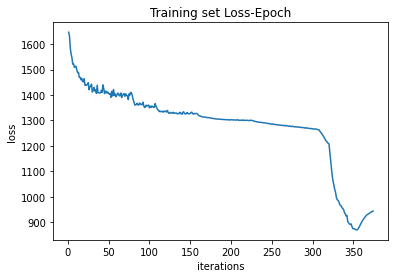

In [ ]:
loss_train_epoch_m = [i.item() for i in loss_train_epoch]
plt.plot([i+1 for i in range(len(iteration_list_train))], loss_train_epoch_m)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("Training set Loss-Epoch")

Text(0.5, 1.0, 'Validation set Loss-iteration')

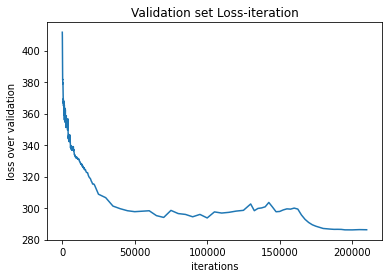

In [ ]:
loss_list_val_m = [i.item() for i in loss_list_val]
plt.plot(iteration_list_val, loss_list_val_m)
plt.xlabel("iterations")
plt.ylabel("loss over validation")
plt.title("Validation set Loss-iteration")

Text(0.5, 1.0, 'Validation set Accuracy-iteration')

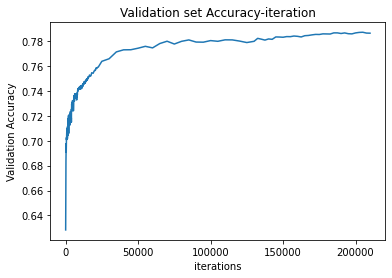

In [ ]:
accuracy_list_val_m = [i for i in accuracy_list_val]
plt.plot(iteration_list_val, accuracy_list_val_m)
plt.xlabel("iterations")
plt.ylabel("Validation Accuracy")
plt.title("Validation set Accuracy-iteration")

Text(0.5, 1.0, 'Training set Accuracy-iteration')

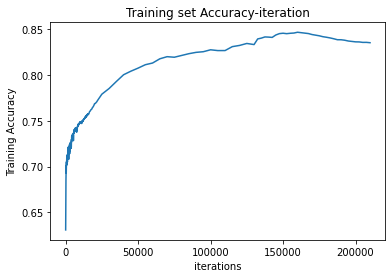

In [ ]:
accuracy_list_train_m = [i for i in accuracy_list_train]
plt.plot(iteration_list_train, accuracy_list_train_m)
plt.xlabel("iterations")
plt.ylabel("Training Accuracy")
plt.title("Training set Accuracy-iteration")

In [ ]:
with open(data_dir + "Models/glove_twitter_avg_fc.sav", "wb") as f:
    pickle.dump(model, f)

Test Accuracy: 0.785432364549695, Test Loss: 358.524169921875
Test Confusion Matrix
Test AUC:  0.8613246230209504


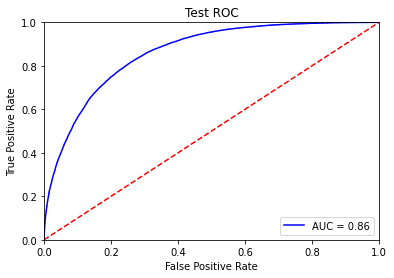

              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83     51093
         1.0       0.72      0.69      0.70     29730

    accuracy                           0.79     80823
   macro avg       0.77      0.77      0.77     80823
weighted avg       0.78      0.79      0.78     80823



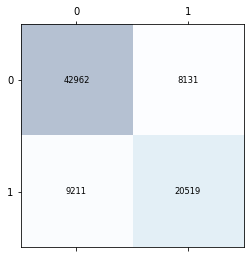

In [ ]:
total = 0
correct = 0
loss = 0
predictions_l = []
labels_l = []
probas_l = []
for images, labels in DataLoader(test_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = model(test)
    loss += error(outputs, labels.reshape(-1, 1)).data
    proba = torch.sigmoid(outputs).reshape(-1)
    probas_l.append(proba)
    predictions = torch.round(torch.sigmoid(outputs)).reshape(-1) #torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum().item()
    predictions_l.append(predictions)
    labels_l.append(labels)
    total += len(labels)
accuracy = correct/total 
print("Test Accuracy: {}, Test Loss: {}".format(accuracy, loss))
print("Test Confusion Matrix")
y_true = torch.cat(labels_l, dim=0).detach().cpu()
y_pred = torch.cat(predictions_l, dim=0).detach().cpu()
y_proba = torch.cat(probas_l, dim=0).detach().cpu()
roc_auc_sc = roc_auc_score(y_true, y_proba)
print("Test AUC: ", roc_auc_sc)
fpr, tpr, threshold = roc_curve(y_true, y_proba)
plt.title('Test ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_sc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')

Val Accuracy: 0.7864101691770018, Val Loss: 286.3896484375
Val Confusion Matrix
Val AUC:  0.8627052842059415


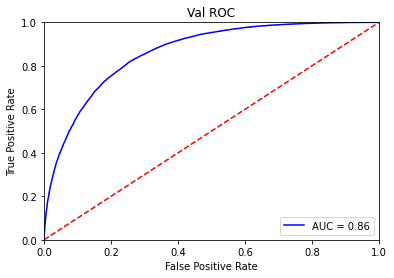

              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83     40630
         1.0       0.72      0.69      0.71     24036

    accuracy                           0.79     64666
   macro avg       0.77      0.77      0.77     64666
weighted avg       0.79      0.79      0.79     64666



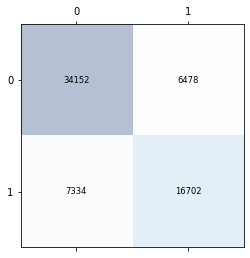

In [ ]:
total = 0
correct = 0
loss = 0
predictions_l = []
labels_l = []
probas_l = []
for images, labels in DataLoader(val_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = model(test)
    loss += error(outputs, labels.reshape(-1, 1)).data
    proba = torch.sigmoid(outputs).reshape(-1)
    probas_l.append(proba)
    predictions = torch.round(torch.sigmoid(outputs)).reshape(-1) #torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum().item()
    predictions_l.append(predictions)
    labels_l.append(labels)
    total += len(labels)
accuracy = correct/total 
print("Val Accuracy: {}, Val Loss: {}".format(accuracy, loss))
print("Val Confusion Matrix")
y_true = torch.cat(labels_l, dim=0).detach().cpu()
y_pred = torch.cat(predictions_l, dim=0).detach().cpu()
y_proba = torch.cat(probas_l, dim=0).detach().cpu()
roc_auc_sc = roc_auc_score(y_true, y_proba)
print("Val AUC: ", roc_auc_sc)
fpr, tpr, threshold = roc_curve(y_true, y_proba)
plt.title('Val ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_sc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')

Train Accuracy: 0.834780524390904, Train Loss: 945.085693359375
Train Confusion Matrix
Train AUC:  0.9146822884569894


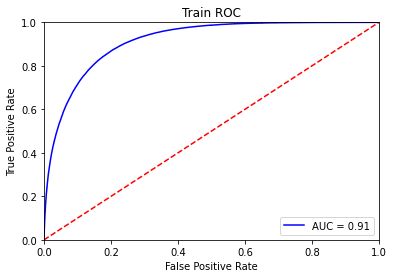

              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87    163169
         1.0       0.79      0.76      0.77     95493

    accuracy                           0.83    258662
   macro avg       0.82      0.82      0.82    258662
weighted avg       0.83      0.83      0.83    258662



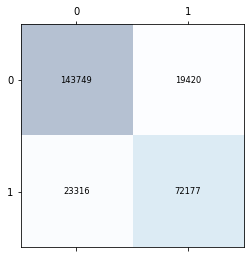

In [ ]:
total = 0
correct = 0
loss = 0
predictions_l = []
labels_l = []
probas_l = []
for images, labels in DataLoader(train_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = model(test)
    loss += error(outputs, labels.reshape(-1, 1)).data
    proba = torch.sigmoid(outputs).reshape(-1)
    probas_l.append(proba)
    predictions = torch.round(torch.sigmoid(outputs)).reshape(-1) #torch.max(outputs, 1)[1].to(device)
    correct += (predictions == labels).sum().item()
    predictions_l.append(predictions)
    labels_l.append(labels)
    total += len(labels)
accuracy = correct/total 
print("Train Accuracy: {}, Train Loss: {}".format(accuracy, loss))
print("Train Confusion Matrix")
y_true = torch.cat(labels_l, dim=0).detach().cpu()
y_pred = torch.cat(predictions_l, dim=0).detach().cpu()
y_proba = torch.cat(probas_l, dim=0).detach().cpu()
roc_auc_sc = roc_auc_score(y_true, y_proba)
print("Train AUC: ", roc_auc_sc)
fpr, tpr, threshold = roc_curve(y_true, y_proba)
plt.title('Train ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_sc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='small')

In [ ]:
interm_model = nn.Sequential(*list(model.children())[:-1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


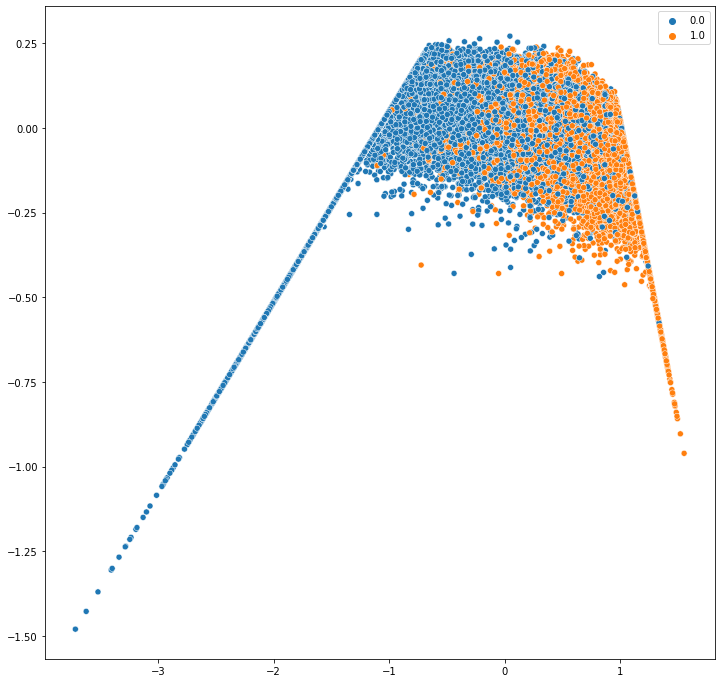

In [ ]:
total = 0
correct = 0
loss = 0
out = []
labels_l = []
for images, labels in DataLoader(val_dataset, batch_size=batch_size):
    images, labels = images.to(device), labels.to(device)
    test = images #.view(batch_size, inp_dim))
    outputs = interm_model(test)
    labels_l.append(labels)
    out.append(outputs)

class pca:
    def __init__(self, n_components):
        """
        :param n_components: Number of principal components the data should be reduced too.
        """
        self.components = n_components

    def fit_transform(self, X):
        """
        * Centering our inputs with mean
        * Finding covariance matrix using centered tensor
        * Finding eigen value and eigen vector using torch.eig()
        * Sorting eigen values in descending order and finding index of high eigen values
        * Using sorted index, get the eigen vectors
        * Tranforming the Input vectors with n columns into PCA components with reduced dimension
        :param X: Input tensor with n columns.
        :return: Output tensor with reduced principal components
        """
        centering_X = X - torch.mean(X, dim=0)
        covariance_matrix = torch.mm(centering_X.T, centering_X)/(centering_X.shape[0] - 1)
        eigen_values, eigen_vectors = torch.eig(covariance_matrix, eigenvectors=True)
        eigen_sorted_index = torch.argsort(eigen_values[:,0],descending=True)
        eigen_vectors_sorted = eigen_vectors[:,eigen_sorted_index]
        component_vector = eigen_vectors_sorted[:,0:self.components]
        transformed = torch.mm(component_vector.T, centering_X.T).T
        return transformed
pca_out = pca(n_components=2).fit_transform(torch.cat(out))
pca_vector = pca_out
plt.figure(figsize=(12, 12))
sb.scatterplot(
    pca_vector[:, 0].detach().cpu(), 
    pca_vector[:, 1].detach().cpu(), 
    hue=torch.cat(labels_l).detach().cpu(), 
    #s=100, 
    palette="tab10"
)
plt.show()